We will select the pre-trained model VGG16 that was trained on Imagenet dataset.

In [ ]:
!pip uninstall tensorflow -y

In [ ]:
!pip install tensorflow==2.12.0

In [ ]:
!pip install tensorflow pillow numpy

In [ ]:
import tensorflow.keras
import scipy as sp
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from PIL import Image
import requests
from io import BytesIO
from tensorflow.keras import backend as K
from tqdm import tqdm

In [ ]:
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")

Tensor Flow Version: 2.12.0
Keras Version: 2.12.0


In [ ]:
# Load the VGG16 model pre-trained on ImageNet data
model = VGG16(weights='imagenet')

In [ ]:
# look at the layers of the model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

**About VGG16 model**  
VGG16 (Visual Geometry Group 16) is a convolutional neural network architecture developed by the Visual Geometry Group at the University of Oxford. It gained popularity after achieving excellent performance in the ImageNet Challenge 2014. VGG16 consists of 16 weight layers — 13 convolutional layers and 3 fully connected layers — with ReLU activations and max pooling layers in between. It has 16 layers with weights which are trainable parameters. But it has total of 22 layers as described below:

*   Input Layer: The first layer is the input layer where the input image is fed into the model.

*   Convolutional Layers: There are 13 convolautional layers to extract features from the input images by applying multiple filters. Small 3x3 filters with stride 1 are used throughout the network, ensuring deeper feature extraction while maintaining computational efficiency. After each convolution, ReLU (Rectified Linear Unit) activation is applied to introduce non-linearity.  

*   Max Pooling Layers: There are 5 max pooling layers after certain numbers of convolutional layers. They are to downsample the feature maps reducing the spatial dimensions while retaining the key features.

*   Fully Connected Layers: There are 3 fully connected layers. After the convolutional and pooling layers, the output is flattened and passed through three fully connected (dense) layers.

*   Output Layer: A softmax activation function is applied in the final layer to produce class probabilities.


**Why VGG16?**


Load the images and test the model.

In [ ]:
# Function to load and preprocess the image from URL
def prepare_image_from_url(img_url):

    response = requests.get(img_url)  # Fetch the image from URL
    img = Image.open(BytesIO(response.content))  # Open the image from the response
    img = img.resize((224, 224))  # Resize to 224x224 (required by VGG16)

    img_array = np.array(img)  # Convert image to array
    if img_array.shape[-1] == 4:  # If image has an alpha channel (RGBA), convert to RGB
        img_array = img_array[..., :3]

    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image for VGG16
    return img_array

# Images URLs
image_urls = [
    'https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/car.jfif',
    'https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/panda.jfif',
    'https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/plane.jfif'
]


# Predict the class for each image
for img_url in image_urls:
    img_array = prepare_image_from_url(img_url)
    preds = model.predict(img_array)
    decoded_preds = decode_predictions(preds, top=1)[0]  # Decode the predictions to readable format

    print(f"Image URL: {img_url}")
    print(f"Predicted: {decoded_preds[0][1]} with probability: {decoded_preds[0][2]:.2f}")
    print("-" * 50)

1/1 [==============================] - 1s 503ms/step
Image URL: https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/car.jfif
Predicted: sports_car with probability: 0.80
--------------------------------------------------
1/1 [==============================] - 0s 365ms/step
Image URL: https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/panda.jfif
Predicted: giant_panda with probability: 0.94
--------------------------------------------------
1/1 [==============================] - 0s 378ms/step
Image URL: https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/plane.jfif
Predicted: airliner with probability: 0.72
--------------------------------------------------


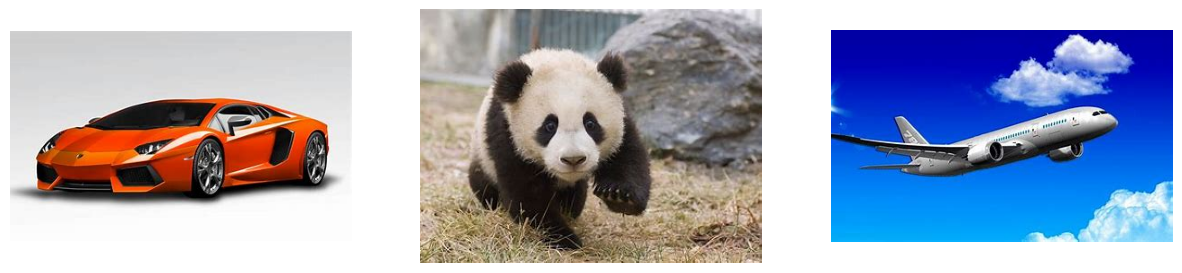

In [ ]:
# Show the test images.
# Function to load the image from URL
def load_image_from_url(img_url):
    response = requests.get(img_url)
    img = Image.open(BytesIO(response.content))  # Open the image from the response
    return img

# Plot the images
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, img_url in enumerate(image_urls):
    img = load_image_from_url(img_url)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes

plt.show()

The first test image is car, second is panda, and third is aeroplane. The model is accurately predicting these test images.

In order to select a multi-channel filter (i.e., a feature) in a layer in which to analyze as part of a circuit, we need to load the model differently.

In [ ]:
model_circuit = VGG16(weights='imagenet', include_top=False, input_tensor=None)

First let's pick a test image, download it and convert the pixel values into a float numpy array

In [ ]:
# Let's pick the panda image for the analysis.
test_img = 'https://raw.githubusercontent.com/yamphurai/Misc/refs/heads/main/panda.jfif'

# load the img, resize it to 150x150, and convert into a numpy float array
def load_img_as_nparray(image_link, size=(150, 150)):

    get_img = requests.get(image_link)   # download img from the link

    # response.content to get raw binary content of the image
    # BytesIO (acts like a virtual file) takes this raw content and wraps them in a file-like object as Image.open expected file-like object and not raw binary data
    img = Image.open(BytesIO(get_img.content))

    img = img.resize(size) # resize with PIL to 150x150
    return np.array(img).astype(float) # convert the PIL iamge to numpy array where each pixel is represented by its color value (float type)

Once we resize the test image to 150x150, let's look at the test image for reference.

In [ ]:
# perform normalization on the pixel values, correct the shape of the img for display
def prepare_img_for_display(img, norm_type='max'):

    # If "mac" normalization, apply min-max scaling otherwise standard deviation scaling. min/max scaling, best for regular images
    if norm_type == 'max':
        new_img = (img - img.min()) / (img.max()-img.min())   # scale pixel values between 0-1 (good for images in preserving original contrast & brightness)
    else:
        new_img = ((img - img.mean()) / (img.std() +1e-3))*0.15 + 0.5  # center pixel values around 0.5 with spread of 0.15 (better if we expect to have outliers/large variations in pixel values)

    new_img *= 255  #convert pixel values 0-1 into 0-255 range (standard for displaying images)
    new_img = np.clip(new_img, 0, 255)  #value < 0 is 0, value > 255 is 255. ensuring pixel values stay in 0-255 range (do after normalization)

    # correct shape for display (height, width, channels). So remove extra dimensions.
    if len(new_img.shape)>3:
        new_img = np.squeeze(new_img)

    return new_img.astype('uint8')  # convert pixel values to unit8 (values range 0-255). expected format for display

Now let's load the test image, prepare it for display, and display it.

(1, 150, 150, 3)


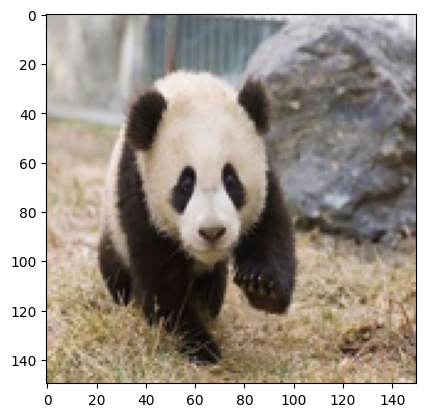

In [ ]:
test_img_tensor = load_img_as_nparray(test_img)  # load the image

# current image shape is (150, 150, 3) but we need (1, 150, 150, 3) where 1 is batch count. expand_dims adds 1 dim at axis=0
test_img_tensor = np.expand_dims(test_img_tensor, axis=0)

# Divide each pixel by 255 to scale them from 0-255 to 0-1 to match the preprocessing step using during model training.
test_img_tensor /= 255.

# image shape after expanding the dim
print(test_img_tensor.shape)

# Show the image
plt.imshow(prepare_img_for_display(test_img_tensor))
plt.show()

The original shape of the image was 224x224. After resizing it to 150x150, we can still all of the details in the image.

In order to find an image that maximally excite a given multi-channels filter, we will need to pick a random image (not a final image like our test image). Random initialization avoids introducing any bias toward existing structures in a real image. Since we don't know a priori which image will maximize the filter's activation, starting with a random image allows the gradient ascent process to modify it to suit the requirements. So, we will use gradient ascent to modify the random image so that chosen filter's activation is maximized.  
The "loss" function we are optimizing is the mean activation of the filter. As the loss increases, the image is getting closer to the "ideal pattern" that maximally excites the filter.

In [ ]:
# Set GPU for computations
physical_device = tf.config.list_physical_devices('GPU')
if physical_device:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
    print("GPU is available and will be used for gradient ascent.")
else:
    print("No GPU found. Using CPU.")

No GPU found. Using CPU.


Optimizing Image: 100%|██████████| 10/10 [00:14<00:00,  1.47s/iteration]


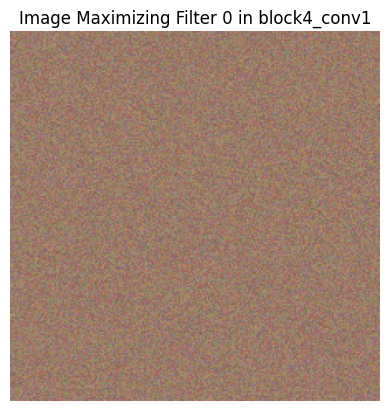

In [ ]:
# Freeze all layers of the model to avoid updating the weights
for layer in model_circuit.layers:
    layer.trainable = False

# Choose the layer and filter to visualize
layer_name = 'block4_conv1'
filter_index = 0  # Index of the filter to visualize

# Initialize a random input image (random noise) of 150x150 & RGB. Scale it in 0-20 range (uniform noise).
# Shift pixel values to be centered around 128. All of these give us grayish image
input_img_data = np.random.random((1, 224, 224, 3)) * 20 + 128

input_img_data = tf.keras.applications.vgg16.preprocess_input(input_img_data)  # Preprocess the input image for VGG16

# input_img_data is numpy array but we it to be a tf tensor for tf.GradientTape
input_img_data = tf.convert_to_tensor(input_img_data, dtype=tf.float32)


# Gradient ascent parameters
step = 1.0  # Step size for gradient ascent
num_iterations = 10  # Number of iterations to run gradient ascent
max_loss = 10.0  # Maximum loss to stop the gradient ascent if it exceeds


# Run gradient ascent with tqdm for progress tracking
for i in tqdm(range(num_iterations), desc="Optimizing Image", unit="iteration"):

    with tf.GradientTape() as tape:
        tape.watch(input_img_data)
        layer_output = model_circuit(input_img_data)
        loss_value = tf.reduce_mean(layer_output[:, :, :, filter_index])

    grads_value = tape.gradient(loss_value, input_img_data)
    grads_value /= (tf.sqrt(tf.reduce_mean(tf.square(grads_value))) + 1e-5)

    # Update the input image with gradient ascent
    input_img_data += step * grads_value

    # Stop if loss exceeds threshold
    if loss_value > max_loss:
        print(f"Stopping early at iteration {i + 1}, loss: {loss_value}")
        break


# Convert the input image data back to a displayable format
input_img_data = input_img_data[0].numpy()  # Convert tensor back to numpy array
input_img_data -= input_img_data.mean()
input_img_data /= (input_img_data.std() + 1e-5)
input_img_data *= 0.1
input_img_data += 0.5
input_img_data = np.clip(input_img_data, 0, 1)


# Display the image that maximally excites the chosen filter
plt.imshow(input_img_data)
plt.title(f"Image Maximizing Filter {filter_index} in {layer_name}")
plt.axis('off')
plt.show()

This is the image that maximally excites our chosen block4_conv1 layer.  
Next we want to try on other random noise images with varying initial conditions and visualize the results side by side. This way we will see how our chosen filter reponnds to those images.

Optimizing Image 5: 100%|██████████| 10/10 [00:14<00:00,  1.48s/iteration]


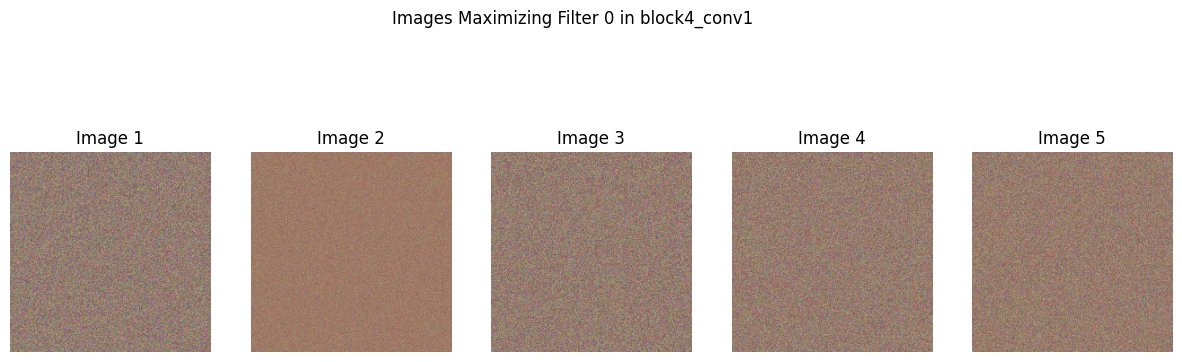

In [ ]:
# Number of images to generate
num_images = 5

fig, axes = plt.subplots(1, num_images, figsize=(15, 5))

for img_idx in range(num_images):
    # Generate a random noise image with different scales
    scale = np.random.uniform(10, 50)  # Vary the noise intensity
    input_img_data = np.random.random((1, 224, 224, 3)) * scale + 128
    input_img_data = tf.keras.applications.vgg16.preprocess_input(input_img_data)
    input_img_data = tf.convert_to_tensor(input_img_data, dtype=tf.float32)

    # Run gradient ascent with tqdm for progress tracking
    for i in tqdm(range(num_iterations), desc=f"Optimizing Image {img_idx+1}", unit="iteration"):
        with tf.GradientTape() as tape:
            tape.watch(input_img_data)
            layer_output_val = model_circuit(input_img_data)
            loss_value = tf.reduce_mean(layer_output_val[:, :, :, filter_index])

        grads_value = tape.gradient(loss_value, input_img_data)
        grads_value /= (tf.sqrt(tf.reduce_mean(tf.square(grads_value))) + 1e-5)

        # Update the input image with gradient ascent
        input_img_data += step * grads_value

        # Stop if loss exceeds threshold
        if loss_value > max_loss:
            print(f"Stopping early at iteration {i + 1}, loss: {loss_value}")
            break

    # Convert back to displayable format
    input_img_data = input_img_data[0].numpy()
    input_img_data -= input_img_data.mean()
    input_img_data /= (input_img_data.std() + 1e-5)
    input_img_data *= 0.1
    input_img_data += 0.5
    input_img_data = np.clip(input_img_data, 0, 1)

    # Display the image
    axes[img_idx].imshow(input_img_data)
    axes[img_idx].axis('off')
    axes[img_idx].set_title(f"Image {img_idx+1}")

plt.suptitle(f"Images Maximizing Filter {filter_index} in {layer_name}")
plt.show()

We are not getting any more additional information using various random images. Next we will use our test image as a reference to see what features react mostly to the chosen filter

In [1]:
input_img_data

NameError: name 'input_img_data' is not defined

In [ ]:
# Resize test image to 224x224 as required by VGG16
test_img_resized = tf.image.resize(test_img_tensor, (224, 224))

# Preprocess the input image for VGG16
input_img_data = tf.keras.applications.vgg16.preprocess_input(test_img_resized)